Its working fine for snr vs mse

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
no_of_sources=5
threshold_prob=0.9999
threshold_prob_range= np.linspace(0.1, 0.99,100)

change random seed below

In [27]:
def source1(no_of_users)->np.ndarray:
    rnd_seed=19
    np.random.seed(rnd_seed)
    return np.random.uniform(-1, 1, (no_of_users))

In [28]:
def pre_process(msg,cha_coeff1,power:float)->np.ndarray:
    print("\t\tx=",msg)
    print("\t\th=",cha_coeff1)
    cha_coeff=np.array(cha_coeff1)
    print("\n\t\t1/h=",1/cha_coeff,"\t\tsqrt(p)=",np.sqrt(power))
    b=np.minimum(1 / (cha_coeff),np.sqrt(power))
    print("\t\tb=",b)
    return msg*b


In [29]:
def awgn_mac_with_channel_coeff(symbols, snr_db,channel_coeff)->np.ndarray:
    print("\t\txb=",symbols)
    faded_symbols=symbols*channel_coeff# This corresponds to y = x_i * h_i
    print("\t\txbh:",faded_symbols)
    combined_faded_symbols = np.sum(faded_symbols)# This corresponds to y = ∑x_i * h_i
    signal_power = np.mean(np.abs(combined_faded_symbols)**2)  # Signal power calculation
    snr_linear = 10**(snr_db / 10.0)
    noise_variance = signal_power / (2 * snr_linear)
    noise =np.sqrt(noise_variance) * np.random.randn()# Noise generation
    print("\t\tn=",noise)
    return combined_faded_symbols + noise

In [30]:
def demod(received_signal,cha_coeff,power:float)->np.ndarray:
    print("\t\tr=",received_signal)
    b=np.minimum(1 / (cha_coeff),np.sqrt(power))
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (1) )
    return received_signal*a_opt

input parmaeters

In [31]:
snr=20
snr_range=np.arange(0,snr+1,5)

available_power=0.004

no_of_slots=4
slots_range=np.arange(1,no_of_slots+1)
iterations=2

if  random seed(j+snr)  channel coeffients are changed for every iteration and each snr

But the results are not as expected

But with more iterations it seems good but not better

parameter:: 0 | chan threshold 0.4590436050264139 | power 0.004
 iter  1 
	slot 1
	cha coeff= [1.76405235 0.40015721 0.97873798 2.2408932  1.86755799] 

		x= [-0.8049328  -0.50612405 -0.72373663 -0.33710687]
		h= [1.76405235 0.97873798 2.2408932  1.86755799]

		1/h= [0.5668766  1.02172391 0.44625063 0.53545861] 		sqrt(p)= 0.06324555320336758
		b= [0.06324555 0.06324555 0.06324555 0.06324555]
		xb= [-0.05090842 -0.0320101  -0.04577312 -0.02132051]
		xbh: [-0.08980512 -0.0313295  -0.10257268 -0.03981729]
		n= -0.18210598071596934
		r= -0.44563056570948817
		r`= -0.18384590423922215
		---------------------------------------------
	slot 2
	cha coeff= [0.95008842] 

		x= [0.52249943]
		h= [0.95008842]

		1/h= [1.05253362] 		sqrt(p)= 0.06324555320336758
		b= [0.06324555]
		xb= [0.03304577]
		xbh: [0.0313964]
		n= -0.0033602218699546904
		r= 0.02803617737999688
		r`= 0.001678601270818546
		---------------------------------------------
	slot 3
	cha coeff= [] 

		x= []
		h= []

		1/h= [] 		sqrt

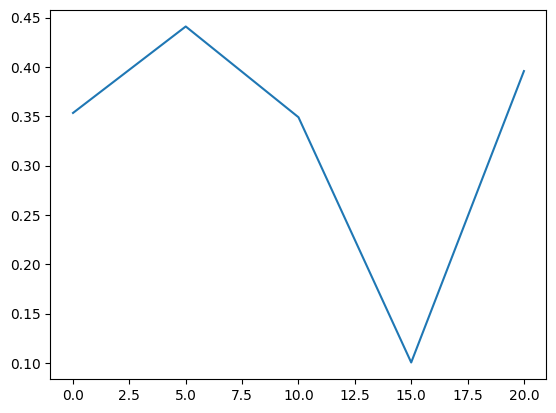

In [32]:
mse=[]
for snr in snr_range: 
    channel_threshold=np.sqrt( 2*np.log(  (1/ (1-(1-threshold_prob )**(1/no_of_slots))  )  ) )
    print("parameter::",snr,"|","chan threshold",channel_threshold,"|","power",available_power)
    error=[]
    for j in range(iterations):
        print(" iter ",j+1,)
        source=source1(no_of_sources)
        # print("main source:",source_main)
        # source=source_main.copy()
        recovered=np.array([])
        
        np.random.seed(j+snr)
        
        for i in slots_range:
            if i<len(slots_range):
                print(f"\tslot {i}")
                channel_coeff=np.random.randn(len(source))
                print("\tcha coeff=",channel_coeff,"\n")
                
                eligible_msgs=source[np.abs(channel_coeff)>channel_threshold]
                
                non_transmitted=source[np.abs(channel_coeff)<=channel_threshold]
                
                channel_gains=channel_coeff[np.abs(channel_coeff)>channel_threshold]
                
                transmitted=pre_process(eligible_msgs,channel_gains,available_power)
                received= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                
                demod_signal=demod(received,channel_gains,available_power)
                recovered=np.append(recovered,demod_signal)
                print("\t\tr`=",demod_signal)
                source=non_transmitted
                print("\t\t---------------------------------------------")           
            
            # Check if it's the last slot
            if i == len(slots_range):
                print(f"\tslot {i}")
                channel_gains=np.random.randn(len(non_transmitted))
                transmitted=pre_process(non_transmitted,channel_gains,available_power)
                
                received= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                demod_signal=demod(received,channel_gains,available_power)
                recovered=np.append(recovered,demod_signal)
                print("\t\tr`=",demod_signal)
                print("\t\t---------------------------------------------")
        print("recovered",recovered)
        print("______________________________________________________________________")
        error.append(np.mean((source.sum() - recovered) ** 2))
    mse.append(np.mean(error))
    
    
print("snr:",snr_range)
print("mse:",mse)
plt.plot(snr_range,mse)
plt.show()